In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as patches
import cmcrameri.cm as cmc
import random
from tqdm.notebook import tqdm
import h5py
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from geopy.distance import geodesic


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
creepmeters = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes_updated.csv')
creepmeters.drop_duplicates('Creepmeter_abbrv',inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XMBC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='TABC'].index,inplace=True)
creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='CHP1'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='CTM1'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='XHR3'].index,inplace=True)
#creepmeters.drop(creepmeters[creepmeters['Creepmeter_abbrv']=='SH30'].index,inplace=True) #needs checking as defintely picks




creepmeters.reset_index(inplace=True,drop=True)
creepmeters_picks = pd.read_csv('../../Data/DATA_tidied/Picks/All_picks_12_JUN_2025.csv',index_col=0)
creepmeters_picks['Start Time'] = pd.to_datetime(creepmeters_picks['Start Time'])
creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Start Time']>dt.datetime(2024,1,1,0,0,0)].index,inplace=True)
#creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Displacement, mm']<0.02].index,inplace=True)
networks = creepmeters['Network'].unique()
networks

array(['EAF', 'PARK', 'UTA', 'NAF', 'HAY', 'CHAF', 'HOL', 'DSF', 'SOCAL',
       'RID', 'CAL'], dtype=object)

EAF
PARK
UTA
NAF
HAY
CHAF
HOL
CWC3
CWC3 36.75 -121.385
Key: CWC3_10.0mins


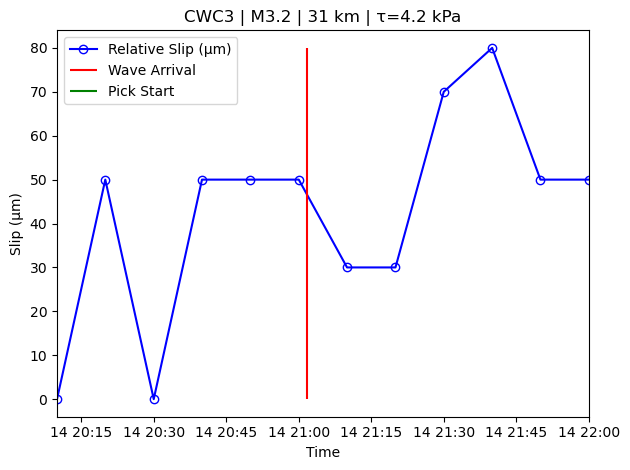

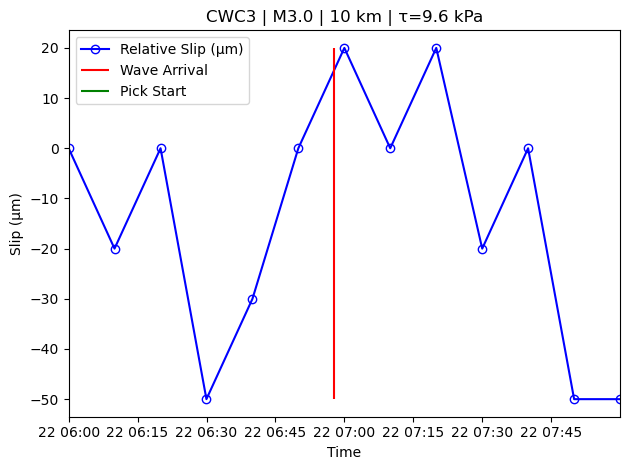

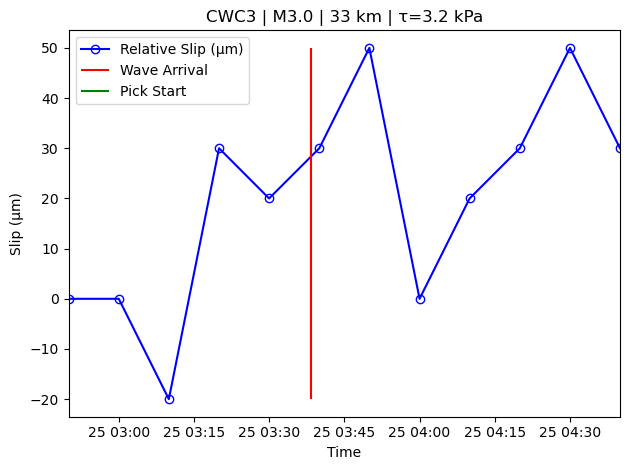

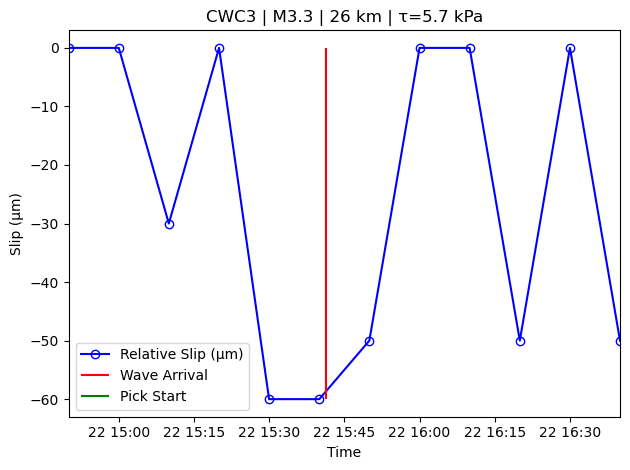

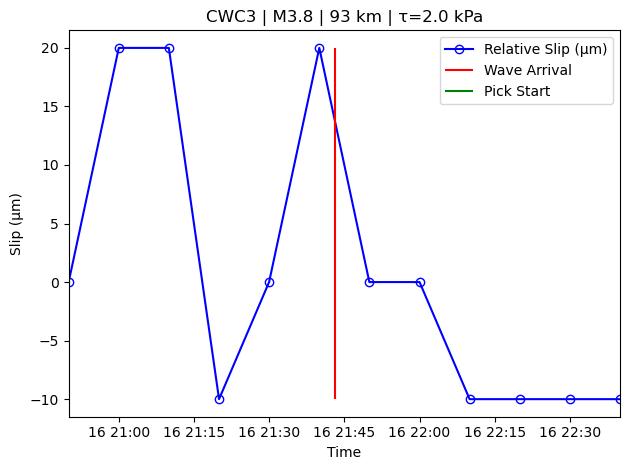

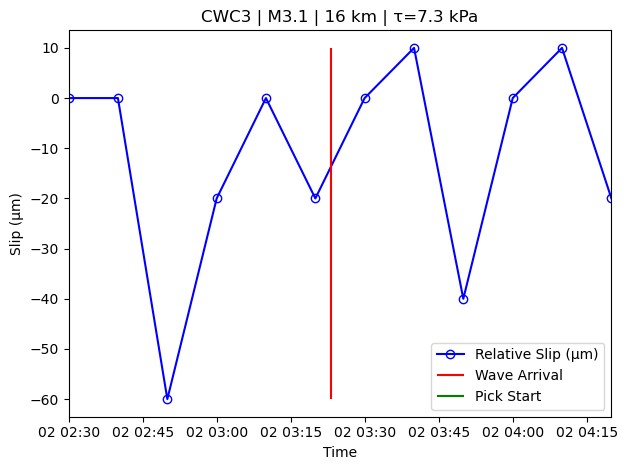

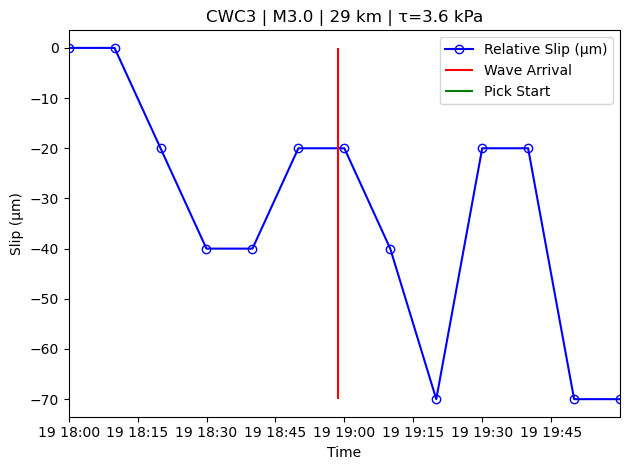

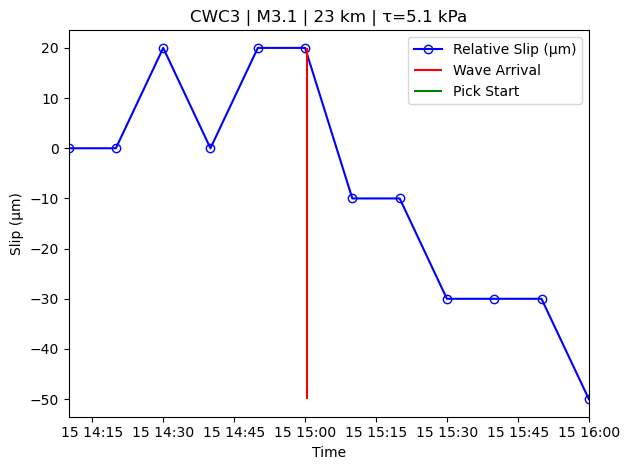

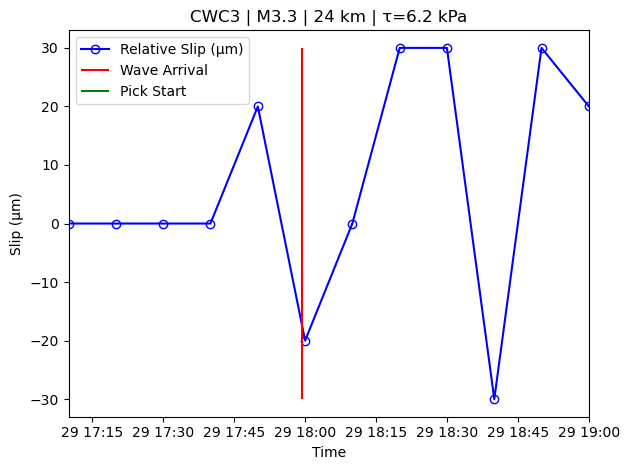

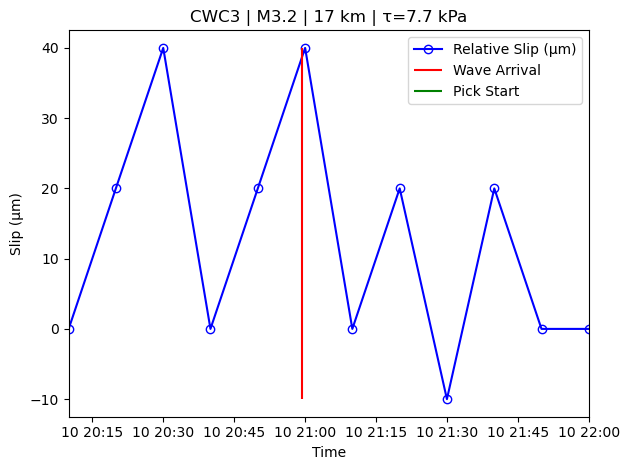

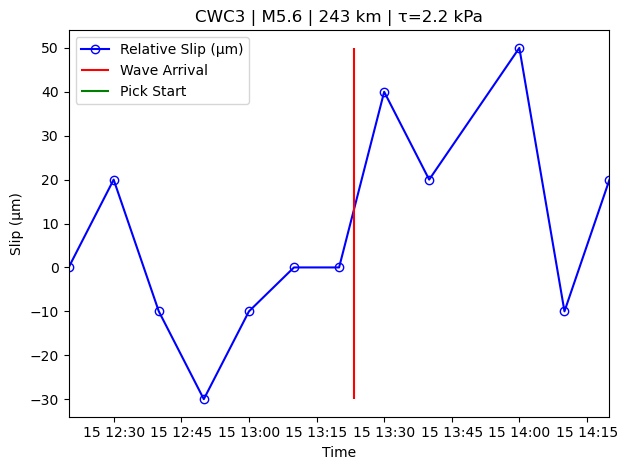

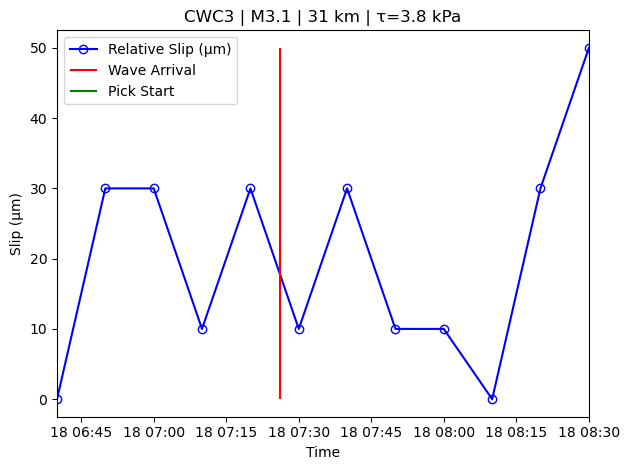

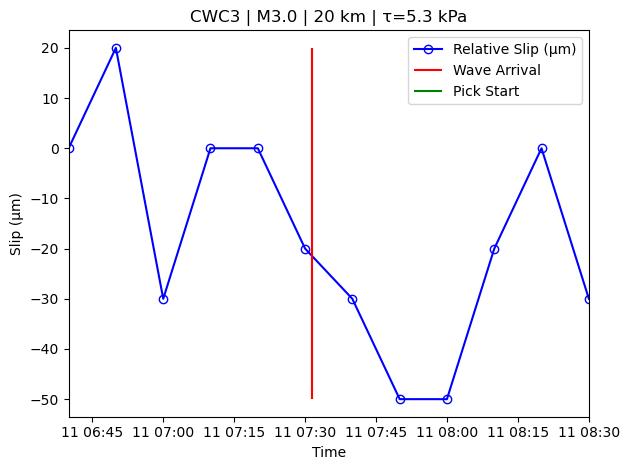

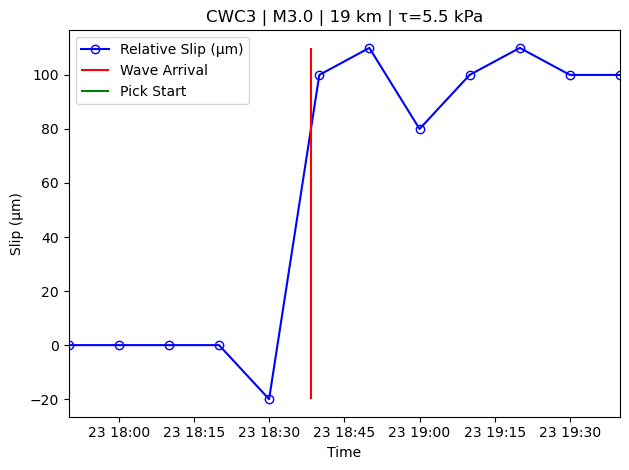

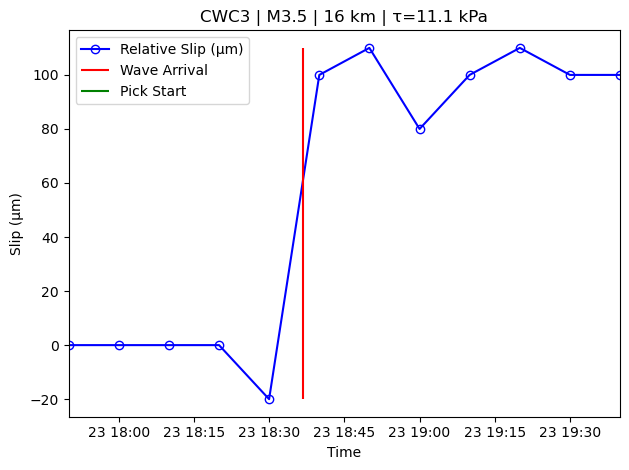

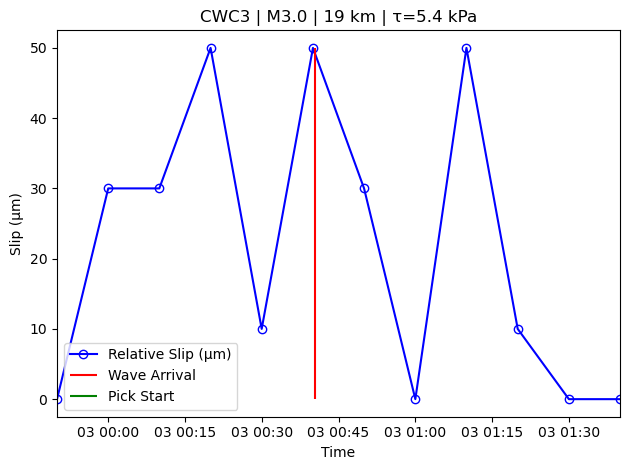

KeyboardInterrupt: Interrupted by user

In [3]:
# Define parameters
radius_km = 500
maxradius_deg = radius_km / 111.0
min_magnitude = 3  # Set minimum magnitude for EQ search

# Containers to store all output across networks
triggered_slip = pd.DataFrame()
percentage_triggered_all = pd.DataFrame()

nearest_slip_data = []

# Loop over each network in your list
for j in range(len(networks)):
    print(networks[j])

    # Limit processing to specific networks of interest
    if networks[j] in ['HOL']:

        # Filter creepmeters to just those in this network
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network'] != networks[j]].index)

        # Loop over each creepmeter in the network
        for i in range(len(creepmeters_network)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]
            print(abbrv)

            # Filter picks (creep events) for this creepmeter
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter abbreviation'] != abbrv].index)

            # Skip if no picks for this creepmeter
            if picks.empty:
                continue

            # Get creepmeter location
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv, lat, long)

            # Extract per-event sampling interval (in seconds)
            sampling_freq = picks['Sampling rate, s']

            # Determine query time window from picks
            starttime = UTCDateTime((pd.to_datetime(picks['Start Time']).min() - pd.DateOffset(months=1)).strftime('%Y-%m-%d'))
            endtime = UTCDateTime((pd.to_datetime(picks['Start Time']).max() + pd.DateOffset(months=1)).strftime('%Y-%m-%d'))

            # Query IRIS FDSN event service
            client = Client("IRIS")
            try:
                catalog = client.get_events(
                    starttime=starttime,
                    endtime=endtime,
                    latitude=lat,
                    longitude=long,
                    maxradius=maxradius_deg,  # ~500 km
                    minmagnitude=min_magnitude
                )
            except Exception as e:
                print(f"Failed to retrieve events for {abbrv}: {e}")
                continue

            # Parse earthquake metadata into DataFrame
            eq_data = []
            for event in catalog:
                origin = event.preferred_origin() or event.origins[0]
                magnitude = event.preferred_magnitude() or event.magnitudes[0]
                eq_data.append({
                    'eq_time': origin.time.datetime,
                    'magnitude': magnitude.mag,
                    'latitude': origin.latitude,
                    'longitude': origin.longitude,
                    'depth_km': origin.depth / 1000.0,
                    'place': event.resource_id.id.split('/')[-1]
                })

            # Create DataFrame
            eq_df = pd.DataFrame(eq_data)

            with h5py.File('../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbrv), 'r') as f:
                df = pd.DataFrame()
                # Loop through each key in the file
                keys = list(f.keys())
                for key in f.keys():
                    if key not in ['Temperature','Temperature_1T','Temperature_5T','Daily_measurements','Manual_measurements','Orthogonal']:
                        print("Key:", key)
                        #print('extracting data')
                        data = f[key]  # Access the dataset
                        data_keys = list(data.keys())
                        #print(data_keys)
                        slip = data[data_keys[0]][:]
                        time =  data[data_keys[1]][:]
                        decoded_time = [byte_str.decode('utf-8') for byte_str in time]
                        decoded_time = pd.to_datetime(decoded_time)
                        df_section = pd.DataFrame({'Time':decoded_time,'Slip':slip})
                        df = pd.concat([df,df_section])
            df.sort_values(by='Time',inplace=True)
            df.reset_index(inplace=True,drop=True)
            

            
            for _, eq in eq_df.iterrows():
                # Step 1: Distance (km) from event to reference location
                dist_km = geodesic((lat, long), (eq['latitude'], eq['longitude'])).km

                # Skip if event is too far to be relevant
                if dist_km > 500:
                    continue

                # Step 2: Estimate PGV using GMPE (Boore et al.)
                a, b, c, d = -1.3, 0.5, 5, -0.003  # GMPE coefficients
                log10_pgv = a + b*eq['magnitude'] - np.log10(dist_km + c) + d*dist_km
                pgv_cms = 10**log10_pgv
                pgv_ms = pgv_cms / 100  # convert to m/s

                # Step 3: Dynamic stress
                rho = 2700  # kg/m³
                vs = 3500   # m/s
                tau_dyn = rho * vs * pgv_ms  # Pascals

                # Skip if dynamic stress is below threshold
                if tau_dyn < 2000:  # 2 kPa
                    continue

                # Step 4: Travel time and wave arrival
                travel_time = dt.timedelta(seconds=dist_km / 3.5)
                arrival_time = np.datetime64(eq['eq_time']) + np.timedelta64(int(travel_time.total_seconds()), 's')

                # Step 5: Find nearest time in df['Time']
                time_diffs = np.abs(np.array(df['Time'], dtype='datetime64[ns]') - arrival_time)
                nearest_s = df['Time'].iloc[np.argmin(time_diffs)]

                # Step 6: Extract ±1 hour around arrival
                mask = (df['Time'] >= nearest_s - dt.timedelta(hours=1)) & \
                    (df['Time'] <= nearest_s + dt.timedelta(hours=1))
                df_eq_time = df[mask].copy()

                if len(df_eq_time) > 0:
                    sample_rate_s = np.median(np.diff(df_eq_time['Time'])) / np.timedelta64(1, 's')

                    if np.isnan(sample_rate_s) or sample_rate_s <= 0:
                        continue  # skip malformed data

                    boolarr_ts = (df['Time'] >= nearest_s) & \
                                (df['Time'] <= nearest_s + dt.timedelta(seconds=sample_rate_s))

                    slip_window = df_eq_time['Slip'][boolarr_ts]

                    if not slip_window.empty:
                        slip_rel = (df_eq_time['Slip'] - df_eq_time['Slip'].iloc[0]) * 1e3  # microns
                        trig_slip = abs(slip_window.iloc[0] - slip_window.iloc[-1]) * 1e3  # microns

                        if trig_slip > 2:  # microns
                            plt.figure()
                            ax = plt.subplot(1, 1, 1)
                            plt.plot(df_eq_time['Time'], slip_rel, color='blue',
                                    marker='o', markersize=6, markerfacecolor='none', label='Relative Slip (µm)')
                            plt.vlines(arrival_time, ymin=slip_rel.min(), ymax=slip_rel.max(), colors='red', label='Wave Arrival')
                            plt.vlines(picks['Start Time'], ymin=slip_rel.min(), ymax=slip_rel.max(), colors='green', label='Pick Start')
                            #plt.ylim([0.9 * slip_rel.min(), 1.1 * slip_rel.max()])
                            plt.xlim([df_eq_time['Time'].min(), df_eq_time['Time'].max()])
                            plt.ylabel('Slip (µm)')
                            plt.xlabel('Time')
                            plt.title(f"{abbrv} | M{eq['magnitude']:.1f} | {dist_km:.0f} km | τ={tau_dyn/1000:.1f} kPa")
                            plt.legend()
                            plt.tight_layout()
                            plt.show()
                            triggered_slip_eq = input("is this triggered slip? (y/n)")
                            if triggered_slip_eq == "y":
                                triggered_slip = pd.concat([triggered_slip,eq])
                            else:
                                continue

In [ ]:
df_eq_time

In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from geopy.distance import geodesic

# Define parameters
radius_km = 1000
maxradius_deg = radius_km / 111.0
min_magnitude = 4  # Set minimum magnitude for EQ search

# Containers to store all output across networks
my_data = pd.DataFrame()
percentage_triggered_all = pd.DataFrame()

# Loop over each network in your list
for j in range(len(networks)):
    print(networks[j])

    # Limit processing to specific networks of interest
    if networks[j] in ['EAF', 'PARK', 'UTA', 'NAF', 'HAY', 'CHAF', 'HOL', 'DSF', 'SOCAL', 'RID', 'CAL']:

        # Filter creepmeters to just those in this network
        creepmeters_network = creepmeters.drop(creepmeters[creepmeters['Network'] != networks[j]].index)

        # Loop over each creepmeter in the network
        for i in range(len(creepmeters_network)):
            abbrv = creepmeters_network['Creepmeter_abbrv'].iloc[i]
            print(abbrv)

            # Filter picks (creep events) for this creepmeter
            picks = creepmeters_picks.drop(creepmeters_picks[creepmeters_picks['Creepmeter abbreviation'] != abbrv].index)

            # Skip if no picks for this creepmeter
            if picks.empty:
                continue

            # Get creepmeter location
            lat = creepmeters_network['Latitude'].iloc[i]
            long = creepmeters_network['Longitude'].iloc[i]
            print(abbrv, lat, long)

            # Extract per-event sampling interval (in seconds)
            sampling_freq = picks['Sampling rate, s']

            # Determine query time window from picks
            starttime = UTCDateTime((pd.to_datetime(picks['Start Time']).min() - pd.DateOffset(months=1)).strftime('%Y-%m-%d'))
            endtime = UTCDateTime((pd.to_datetime(picks['Start Time']).max() + pd.DateOffset(months=1)).strftime('%Y-%m-%d'))

            # Query IRIS FDSN event service
            client = Client("IRIS")
            try:
                catalog = client.get_events(
                    starttime=starttime,
                    endtime=endtime,
                    latitude=lat,
                    longitude=long,
                    maxradius=maxradius_deg,  # ~500 km
                    minmagnitude=min_magnitude
                )
            except Exception as e:
                print(f"Failed to retrieve events for {abbrv}: {e}")
                continue

            # Parse earthquake metadata into DataFrame
            eq_data = []
            for event in catalog:
                origin = event.preferred_origin() or event.origins[0]
                magnitude = event.preferred_magnitude() or event.magnitudes[0]
                eq_data.append({
                    'eq_time': origin.time.datetime,
                    'magnitude': magnitude.mag,
                    'latitude': origin.latitude,
                    'longitude': origin.longitude,
                    'depth_km': origin.depth / 1000.0,
                    'place': event.resource_id.id.split('/')[-1]
                })

            eq_df = pd.DataFrame(eq_data)
            picks['Start Time'] = pd.to_datetime(picks['Start Time'])
            eq_df['eq_time'] = pd.to_datetime(eq_df['eq_time'])

            # Search for plausible EQ triggers based on wave arrival time
            expanded_matches = []
            for idx, pick in picks.iterrows():
                start_time = pick['Start Time']
                sampling_interval = pick['Sampling rate, s']

                valid_trigger_found = False
                best_match = None
                best_time_diff = np.inf

                for _, eq in eq_df.iterrows():
                    dist_km = geodesic((lat, long), (eq['latitude'], eq['longitude'])).km
                    travel_time = dist_km / 3.5
                    time_since_eq = (start_time - eq['eq_time']).total_seconds()
                    upper_bound = travel_time + 2 * sampling_interval + 1.0 * sampling_interval + 60

                    if travel_time <= time_since_eq <= upper_bound:
                        if time_since_eq < best_time_diff:
                            valid_trigger_found = True
                            best_time_diff = time_since_eq
                            best_match = {
                                'Start Time': start_time,
                                'abbrv': abbrv,
                                'eq_time': eq['eq_time'],
                                'magnitude': eq['magnitude'],
                                'latitude': eq['latitude'],
                                'longitude': eq['longitude'],
                                'depth_km': eq['depth_km'],
                                'place': eq['place'],
                                'Time Since EQ [s]': time_since_eq,
                                'Surface Wave Travel Time [s]': travel_time,
                                'Upper Tolerance Bound [s]': upper_bound,
                                'Likely Triggered': True,
                                'Sampling Interval [s]': sampling_interval,
                                'Latitude_creep': lat,
                                'Longitude_creep': long
                            }

                if not valid_trigger_found:
                    best_match = {
                        'Start Time': start_time,
                        'abbrv': abbrv,
                        'eq_time': pd.NaT,
                        'magnitude': np.nan,
                        'latitude': np.nan,
                        'longitude': np.nan,
                        'depth_km': np.nan,
                        'place': None,
                        'Time Since EQ [s]': np.nan,
                        'Surface Wave Travel Time [s]': np.nan,
                        'Upper Tolerance Bound [s]': np.nan,
                        'Likely Triggered': False,
                        'Sampling Interval [s]': sampling_interval,
                        'Latitude_creep': lat,
                        'Longitude_creep': long
                    }

                expanded_matches.append(best_match)

            nearest_eq_df = pd.DataFrame(expanded_matches)

            # Compute percentage of events considered valid triggers
            count_valid = nearest_eq_df['Likely Triggered'].sum()
            percent_valid = 100 * count_valid / len(picks)

            print(f"{percent_valid:.2f}% of {len(picks)} events have valid earthquake triggers (wave arrival + resolution buffer).")

            percentage_triggered = pd.DataFrame({
                'Creepmeter': [abbrv],
                'percentage valid triggers': [round(percent_valid, 2)],
                'Latitude': lat
            })

            creepmeter_eq_picks = pd.concat([picks.reset_index(drop=True), nearest_eq_df.reset_index(drop=True)], axis=1)
            my_data = pd.concat([my_data, creepmeter_eq_picks])
            percentage_triggered_all = pd.concat([percentage_triggered_all, percentage_triggered])

        percentage_triggered_all.sort_values(by='Latitude', inplace=True, ascending=False)
        percentage_triggered_all.reset_index(inplace=True, drop=True)

my_data.to_csv("triggered_creep_events_matched_to_nearest_EQ.csv", index=False)
percentage_triggered_all.to_csv("triggered_creep_percentage_summary.csv", index=False)
